### Описание эксперимента:
Есть мобильное приложение. В этом приложении у пользователей есть возможность покупать игровые предметы за реальные деньги. Чтобы стимулировать пользователей их покупать, приложение периодически предлагает пользователям товары - появляется окошко с рекомендацией купить товар. Отдел машинного обучения предложил улучшение для текущего алгоритма выбора рекомендации. Для проверки улучшений алгоритма был проведен A/B тест. Лог его проведения предоставлен в прикрепленном файле. 

### Метрика: 
Cредний доход от пользователя за 1 неделю после первого показа ему рекомендации на 10% (после начала A/B теста время первого показа ищется снова)

### Важная информация
Эксперимент начинается 2023-05-01. Данные есть до 2023-06-01 (но можно завершить раньше, если это позволит оценка длительности)

Вам сказали, что его длительность должна составить 1 месяц.

Все покупки, которые вызваны не влиянием рекомендаций, в этом логе не учитываются

### Описание данных
- id_product -  идентификатор продукта, который был рекомендован
- is_pay - купил ли пользователь товар
- sum_payment - размер платежа (0, если не купил)
- city - город, в котором находится пользователь
- id_user - пользователь
- timestamp - timestamp события
- date - дата события

### Задачи, которые необходимо решить
Оценить длительность теста на момент его начала. Сравнить с предложенной. Для оценки необходимо использовать данные с пред экспериментального периода. 

Посмотреть, есть ли выбросы в данных.

Построить методику расчета целевой метрики. Рассчитать целевую метрику на день окончания теста (рассчитанной в п1) для группы A и B, рассчитать эффект, p_value. Посмотреть, есть ли выбросы в данных.

Рассчитать метрики из п2 по дням и построить их графики.

Принять решение о результате теста - обосновать.

### Дополнительно
При подсчете метрик обработать выбросы в данных - описать почему их можно удалить из теста, если они удаляются. 

Пожалуйста, не заглядывайте в будущее по данным, если рассчитанная длительность меньше предоставленных данных.

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as sps
import plotly.graph_objs as go
import seaborn as sns
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv("ab_made.gzip", compression='gzip')
df

,timestamp,id_user,sum_payment,group,city,id_product,is_pay,date
0,1680330573,user_9903,27,NaN,Санкт-Петербург,4.0,1,2023-04-01
1,1680332652,user_6732,0,NaN,Рязань,1.0,0,2023-04-01
2,1680378039,user_4199,0,NaN,Москва,3.0,0,2023-04-01
3,1680337580,user_3606,12,NaN,Санкт-Петербург,7.0,1,2023-04-01
4,1680334389,user_9519,0,NaN,Санкт-Петербург,14.0,0,2023-04-01
...,...,...,...,...,...,...,...,...
56400,1685485266,user_10740,0,A,Санкт-Петербург,14.0,0,2023-05-31
56401,1685481632,user_3589,0,B,Санкт-Петербург,1.0,0,2023-05-31
56402,1685514383,user_10664,13,A,Москва,17.0,1,2023-05-31
56403,1685481325,user_3537,0,B,Ярославь,19.0,0,2023-05-31


In [86]:
df_before = df[df['date'] < '2023-05-01']
print('Выбросов:', df_before[df_before['sum_payment'] > 500].shape[0])
df_before = df_before[df_before['sum_payment'] < 500]
df_before.sample(3)

Выбросов: 1


,timestamp,id_user,sum_payment,group,city,id_product,is_pay,date
7161,1681961727,user_1724,25,NaN,Рязань,12.0,1,2023-04-20
244,1680591735,user_5725,0,NaN,Ярославь,0.0,0,2023-04-04
1380,1681148224,user_8755,14,NaN,Тула,13.0,1,2023-04-10


<AxesSubplot:xlabel='id_product', ylabel='Count'>

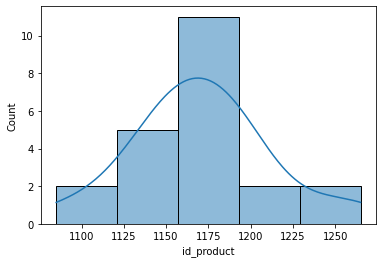

In [104]:
sns.histplot(df_before['id_product'].value_counts(), bins=5, kde=True)

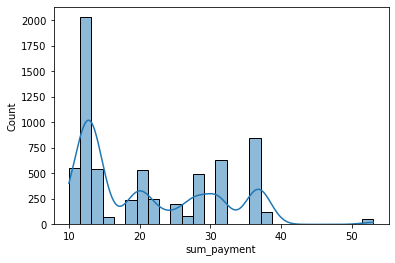

In [82]:
sns.histplot(df_before[df_before['sum_payment'] > 0]['sum_payment'], kde=True);

In [4]:
df['date'].min()

'2023-04-01'

In [7]:
df['id_user'].unique().shape[0]

12000

In [42]:
df_new = df.groupby('id_user').min().reset_index()[['id_user', 'date']]
df_new.columns = ['id_user', 'date_first']
df_new

,id_user,date_first
0,user_0,2023-04-13
1,user_1,2023-04-30
2,user_10,2023-04-27
3,user_100,2023-04-17
4,user_1000,2023-04-23
...,...,...
11995,user_9995,2023-04-29
11996,user_9996,2023-04-27
11997,user_9997,2023-04-30
11998,user_9998,2023-04-29


In [48]:
df.join(df_new.set_index('id_user'), on='id_user')

,timestamp,id_user,sum_payment,group,city,id_product,is_pay,date,date_first
0,1680330573,user_9903,27,NaN,Санкт-Петербург,4.0,1,2023-04-01,2023-04-01
1,1680332652,user_6732,0,NaN,Рязань,1.0,0,2023-04-01,2023-04-01
2,1680378039,user_4199,0,NaN,Москва,3.0,0,2023-04-01,2023-04-01
3,1680337580,user_3606,12,NaN,Санкт-Петербург,7.0,1,2023-04-01,2023-04-01
4,1680334389,user_9519,0,NaN,Санкт-Петербург,14.0,0,2023-04-01,2023-04-01
...,...,...,...,...,...,...,...,...,...
56400,1685485266,user_10740,0,A,Санкт-Петербург,14.0,0,2023-05-31,2023-05-24
56401,1685481632,user_3589,0,B,Санкт-Петербург,1.0,0,2023-05-31,2023-04-25
56402,1685514383,user_10664,13,A,Москва,17.0,1,2023-05-31,2023-05-23
56403,1685481325,user_3537,0,B,Ярославь,19.0,0,2023-05-31,2023-04-10


In [37]:
df.groupby('id_user').min().reset_index()[['id_user', 'date']]

,id_user,date
0,user_0,2023-04-13
1,user_1,2023-04-30
2,user_10,2023-04-27
3,user_100,2023-04-17
4,user_1000,2023-04-23
...,...,...
11995,user_9995,2023-04-29
11996,user_9996,2023-04-27
11997,user_9997,2023-04-30
11998,user_9998,2023-04-29


In [107]:
df.groupby(by=['id_user', 'date'])